In [1]:
import torch
import import_ipynb
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Normalize, Compose, Resize, RandomHorizontalFlip,RandomResizedCrop
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection

import matplotlib.pyplot as plt
import torch.optim as optim
import math

## DETR Model

## Positional encoding

In [3]:
class SimpleDetr(nn.Module):
    
## positional embedding
    @staticmethod
    def position_embedding_sine(tensor_list, num_pos_feats=64, temperature=10000, normalize=False, scale=None):
        x = tensor_list.tensors
        print(f"x:{x}")
    
        mask = tensor_list.mask
        assert mask is not None
        not_mask = ~mask
        y_embed = not_mask.cumsum(1, dtype=torch.float32)
        x_embed = not_mask.cumsum(2, dtype=torch.float32)
        if normalize:
            eps = 1e-6
            y_embed = y_embed / (y_embed[:, -1:, :] + eps) * (2 * math.pi)
            x_embed = x_embed / (x_embed[:, :, -1:] + eps) * (2 * math.pi)

        dim_t = torch.arange(num_pos_feats, dtype=torch.float32, device=x.device)
        dim_t = temperature ** (2 * (dim_t // 2) / num_pos_feats)

        pos_x = x_embed[:, :, :, None] / dim_t
        pos_y = y_embed[:, :, :, None] / dim_t
        pos_x = torch.stack((pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos_y = torch.stack((pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)
        return pos
    
    @staticmethod
    def position_embedding_learned(tensor_list, num_pos_feats=256):
        x = tensor_list.tensors
        h, w = x.shape[-2:]
        i = torch.arange(w, device=x.device)
        j = torch.arange(h, device=x.device)
        x_emb = nn.Embedding(50, num_pos_feats)(i)
        y_emb = nn.Embedding(50, num_pos_feats)(j)
        pos = torch.cat([
            x_emb.unsqueeze(0).repeat(h, 1, 1),
            y_emb.unsqueeze(1).repeat(1, w, 1),
        ], dim=-1).permute(2, 0, 1).unsqueeze(0).repeat(x.shape[0], 1, 1, 1)
        return pos


    @staticmethod
    def build_position_encoding(args):
        N_steps = args.hidden_dim // 2
        if args.position_embedding in ('v2', 'sine'):
            position_embedding = SimpleDetr.position_embedding_sine
        elif args.position_embedding in ('v3', 'learned'):
            position_embedding =SimpleDetr.position_embedding_learned
        else:
            raise ValueError(f"not supported {args.position_embedding}")

        return position_embedding


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class TensorList:
    def __init__(self, tensors, mask):
        self.tensors = tensors
        self.mask = mask

# Assume images is your batch of images and masks is the corresponding batch of masks
images = torch.rand(4, 3, 512, 512)
masks = torch.randint(0, 2, (4, 512, 512), dtype=torch.bool)

        
tensor_list = TensorList(images, masks)

x:tensor([[[[9.7280e-01, 4.4947e-01, 2.4668e-01,  ..., 2.6298e-01,
           9.8676e-02, 2.3407e-01],
          [1.3153e-01, 9.6657e-01, 9.7253e-01,  ..., 3.4577e-01,
           8.8701e-01, 5.4732e-01],
          [5.0573e-01, 4.3958e-01, 9.7573e-01,  ..., 8.5340e-01,
           5.6660e-01, 5.6714e-01],
          ...,
          [7.2707e-01, 3.9011e-02, 2.7009e-01,  ..., 9.1169e-02,
           9.6968e-01, 1.5567e-01],
          [4.5707e-01, 3.4929e-01, 4.5512e-01,  ..., 4.3536e-01,
           1.1974e-01, 7.9959e-01],
          [2.6353e-01, 4.1569e-01, 6.5344e-02,  ..., 5.6559e-01,
           9.7379e-01, 9.9213e-01]],

         [[3.6696e-01, 4.7125e-01, 3.9908e-01,  ..., 3.9585e-01,
           4.8894e-01, 4.9718e-01],
          [8.0305e-01, 7.2619e-01, 1.9090e-01,  ..., 7.0953e-01,
           2.2424e-01, 1.4467e-01],
          [1.7542e-01, 5.8356e-01, 3.4378e-01,  ..., 2.7830e-01,
           6.1459e-01, 3.6205e-01],
          ...,
          [2.2698e-01, 6.2118e-01, 7.4486e-01,  ..., 2.65

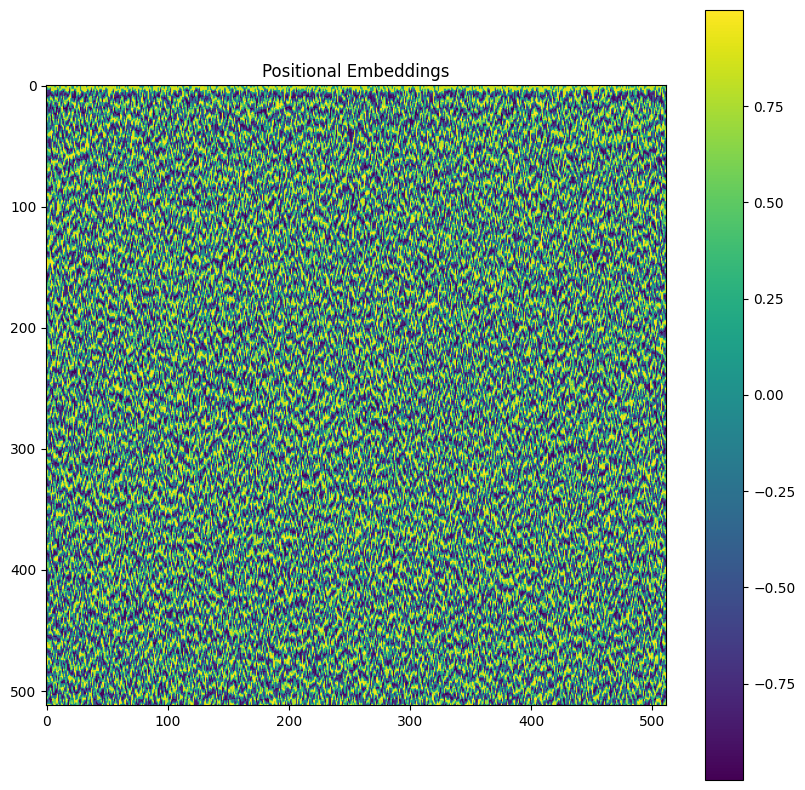

In [5]:
import matplotlib.pyplot as plt

# Assume pos is your positional embedding tensor
pos = SimpleDetr.position_embedding_sine(tensor_list)

# Convert tensor to numpy array
pos_np = pos.detach().numpy()

# Plot the positional embeddings
plt.figure(figsize=(10,10))
plt.imshow(pos_np[0][0], cmap='viridis')
plt.colorbar()
plt.title('Positional Embeddings')
plt.show()

# InputEmbeddings

tensor([[[-18.7656,   5.4499,   1.3442,  ..., -30.5440,  -5.4096,  16.4352],
         [ -4.5086, -29.0936,   3.2893,  ..., -35.7406, -10.8095,  -2.7428],
         [-35.4751, -17.1265, -17.6715,  ..., -24.6692,  18.8854,   5.1831],
         ...,
         [ -6.5806,   5.2446,  27.3535,  ...,  20.0406,   2.3865, -20.3994],
         [-15.5295,  26.6877,   5.7768,  ...,  36.0142, -15.8686,  -8.4234],
         [  4.5509, -11.6658, -34.5228,  ...,   5.7238,  -7.5140,  11.2821]],

        [[ 25.8341, -26.3343, -31.4132,  ..., -31.0960,  -7.6242,  17.5082],
         [-11.5079,   4.4785,  33.4587,  ...,   5.9712,  11.8310,   8.5935],
         [  4.2997,  10.9930,   0.5519,  ..., -15.3182,  24.3972,  -6.5823],
         ...,
         [ 18.5643,  31.9285,   4.0406,  ...,  -6.3743,  24.2264, -25.9420],
         [-28.1902,  32.1644,  11.5143,  ...,  19.0098,  -7.4575,   5.8569],
         [-15.5295,  26.6877,   5.7768,  ...,  36.0142, -15.8686,  -8.4234]],

        [[ 15.2267, -15.3942, -13.1529,  ...

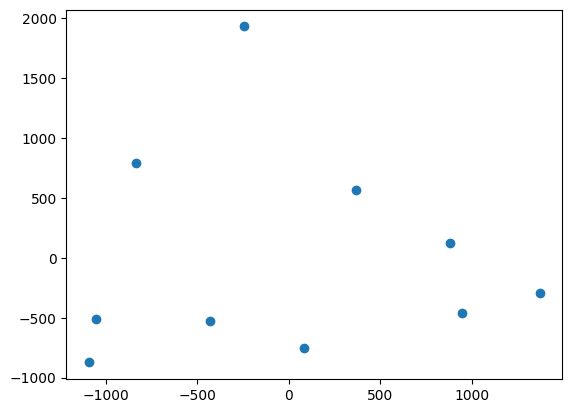

In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

class InputEmbeddings(nn.Module):

    def __init__(self, d_model: int, feature_dim: int) -> None: # d_model = 512 dimension of model, feature_dim = is the dimension of the input features for each bounding box 
        super().__init__()
        self.d_model = d_model
        self.feature_dim = feature_dim
        self.embedding = nn.Embedding(feature_dim, d_model)

    def forward(self, x):
        # (batch, feature_dim) --> (batch, feature_dim, d_model)
        # Multiply by sqrt(d_model) to scale the embeddings according to the paper
        return self.embedding(x) * math.sqrt(self.d_model)
    
    
    
# Create an instance of the class
input_embeddings = InputEmbeddings(d_model=512, feature_dim=100)

# Create some example input data
x = torch.randint(high=100, size=(10, 100))  # batch of 10 sequences, each sequence has 100 bounding boxes

# Pass the input data through the model
output = input_embeddings(x)

# Print the output
print(output)
print (output.shape)


# Flatten the output tensor and convert it to numpy
output_np = output.view(output.shape[0], -1).detach().numpy()

# Apply PCA
pca = PCA(n_components=2)
output_pca = pca.fit_transform(output_np)

# Plot the PCA-transformed embeddings
plt.scatter(output_pca[:, 0], output_pca[:, 1])
plt.show()

## FeedForwardBloc

In [ ]:
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, hidden_dim: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, hidden_dim) # w1 and b1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(hidden_dim, d_model) # w2 and b2

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, hidden_dim) --> (batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

## MultiHeadAttentionBlock

In [ ]:
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Embedding vector size
        self.h = h # Number of heads
        # Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        # Just apply the formula from the paper
        # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            # Write a very low value (indicating -inf) to the positions where mask == 0
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1) # (batch, h, seq_len, seq_len) # Apply softmax
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)
        # return attention scores which can be used for visualization
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        # Calculate attention
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)
        
        # Combine all the heads together
        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # Multiply by Wo
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)  
        return self.w_o(x)

## LayerNormalization

In [ ]:
class LayerNormalization(nn.Module):

    def __init__(self, features: int, eps:float=10**-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(features)) # alpha is a learnable parameter
        self.bias = nn.Parameter(torch.zeros(features)) # bias is a learnable parameter

    def forward(self, x):
        # x: (batch, seq_len, hidden_size)
         # Keep the dimension for broadcasting
        mean = x.mean(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # Keep the dimension for broadcasting
        std = x.std(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # eps is to prevent dividing by zero or when std is very small
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

## ResidualConnection

In [ ]:
class ResidualConnection(nn.Module):
    
        def __init__(self, features: int, dropout: float) -> None:
            super().__init__()
            self.dropout = nn.Dropout(dropout)
            self.norm = LayerNormalization(features)
    
        def forward(self, x, sublayer):
            return x + self.dropout(sublayer(self.norm(x)))

## EncoderBlock

In [ ]:
class EncoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))  # (batch, seq_len, d_model), x means q, k, v and src_mask means mask
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x
    


## Encoder

In [ ]:
class Encoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

## DecoderBlock

In [ ]:
class DecoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

## Decoder

In [ ]:
class Decoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

## ProjectionLayer

In [ ]:
#class ProjectionLayer(nn.Module):

    #def __init__(self, d_model, vocab_size) -> None:
        #super().__init__()
        #self.proj = nn.Linear(d_model, vocab_size)

    #def forward(self, x) -> None:
        # (batch, seq_len, d_model) --> (batch, seq_len, vocab_size)
        #return self.proj(x)
    
class ProjectionLayer(nn.Module):

    def __init__(self, d_model, num_classes, box_dim) -> None: # d_model = 256, num_classes = 91, box_dim = 4
        super().__init__()
        self.class_proj = nn.Linear(d_model, num_classes)
        self.box_proj = nn.Linear(d_model, box_dim)

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, num_classes)
        class_logits = self.class_proj(x)
        # (batch, seq_len, d_model) --> (batch, seq_len, box_dim)
        box_regression = self.box_proj(x)
        return class_logits, box_regression

## Transformer

In [ ]:
self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

In [ ]:
class Transformer(nn.Module):

    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: SimpleDetr, tgt_pos: SimpleDetr, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        # (batch, seq_len, d_model)
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)
    
    def decode(self, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt: torch.Tensor, tgt_mask: torch.Tensor):
        # (batch, seq_len, d_model)
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)
    
    def project(self, x):
        # (batch, seq_len, vocab_size)
        return self.projection_layer(x)
    
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int=512, N: int=6, h: int=8, dropout: float=0.1, d_ff: int=2048) -> Transformer:
    # Create the embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

    # Create the positional encoding layers
    src_pos = SimpleDetr(d_model, src_seq_len, dropout)
    tgt_pos = SimpleDetr(d_model, tgt_seq_len, dropout)
    
    # Create the encoder blocks
    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(d_model, encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    # Create the decoder blocks
    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(d_model, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)
    
    # Create the encoder and decoder
    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))
    
    # Create the projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)
    
    # Create the transformer
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)
    
    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    return transformer